In [1]:
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt
%matplotlib inline  
import pandas as pd
from time import clock,time
import csv
import re
import seaborn as sns


In [2]:
from matplotlib.colors import ListedColormap
my_cmap = sns.cubehelix_palette(80, start=2, rot=0, dark=0, light=.9, reverse=False)
my_cmap[0] = (1.,1.,1.)
my_cmap = ListedColormap(my_cmap)


# Package dependency:
* hmmlearn. Install by pip install hmmlearn.
* runtime approx 30 minutes.

# 1. Experimental sanity check
* Test this implementation of Baum-Welch recovers emission and transition probabilities as expected.

In [3]:
sample = lambda prob: np.where(np.random.multinomial(1,prob)==1)[0][0]

def simulate(nsteps, pi, A, B):
    '''
    Input = parameters of an HMM.
    Output = simulated observation sequence of length nsteps.
    '''
    Z = np.zeros(nsteps, dtype=int) # latent states
    observations = np.zeros(nsteps, dtype=int) # emissions  
    
    # markov through states
    Z[0] = sample(pi)
    for t in range(1,nsteps):
        Z[t] = sample(A[Z[t-1],:])
        
    # get corresponding emissions  
    for t in range(nsteps):
        observations[t] = sample(B[Z[t],:])
    return observations

In [4]:
def gen_jitter(X, den): 
    '''
    Input = matrix
    Output = matrix after lifting all cells above zero without harming the condition that rows should sum to 1.
    '''
    jitter = np.random.random(X.shape[0]*X.shape[1]).reshape(X.shape)/den
    Y = jitter + X
    for i in range(X.shape[0]):
        Y[i,:] = Y[i,:]/np.sum(Y[i,:])
    return Y


* Define arbitrary "true" emission, transition and start probabilities.

In [5]:
pi_true = np.ones(5)/5.
E_true = np.zeros((5,5))
for i in range(5):
    E_true[i,i] = 0.7
    if i==0:
        E_true[i,i+1] = .3
    elif i==4:
        E_true[i,i-1] = .3
    else:
        E_true[i,i-1] = .15
        E_true[i,i+1] = .15
T_true = E_true


* Simulate multiple observation sequences of random length between 5 and 8.

In [6]:
careers_all = []
for i in range(200):
    careers_all.append(simulate(np.random.randint(5,8), pi_true, T_true, E_true))
careers_all[:5]


[array([3, 3, 4, 4, 4]),
 array([2, 0, 2, 2, 3]),
 array([2, 3, 2, 1, 1]),
 array([2, 2, 2, 2, 3]),
 array([1, 0, 0, 1, 1, 1])]

* Train HMM.

In [7]:
X = np.concatenate(careers_all)
lengths = [len(career) for career in careers_all]

model = hmm.MultinomialHMM(n_components=5, n_iter=1000,params='ste',tol=0.01, init_params='')

# choose jittered identity matrices as starting guesses for emission and transition probabilities.
# these will be similar to our starting guesses for real occupational data.
# note if you start with the identity matrix sans jitter, 
# Baum-Welch, sensitive to local maxima, is at great risk of not moving. 
model.startprob_ = np.ones(5)/5.
model.transmat_ = gen_jitter(np.eye(5), 25)
model.emissionprob_ = gen_jitter(np.eye(5), 25)

fitted=model.fit(np.atleast_2d(X).T, lengths)


In [8]:
print "E_estimated:\n", np.round(fitted.emissionprob_,2)
print "E_true:\n", E_true
print ''
print "T_estimated:\n", np.round(fitted.transmat_,2)
print "T_true:\n", T_true
print ''
print "pi_estimated:\n", np.round(fitted.startprob_,2)
print "pi_true:\n", pi_true
print ''

E_estimated:
[[ 0.56  0.37  0.07  0.    0.  ]
 [ 0.07  0.8   0.13  0.    0.  ]
 [ 0.    0.13  0.76  0.09  0.02]
 [ 0.    0.01  0.17  0.82  0.  ]
 [ 0.    0.    0.07  0.4   0.53]]
E_true:
[[ 0.7   0.3   0.    0.    0.  ]
 [ 0.15  0.7   0.15  0.    0.  ]
 [ 0.    0.15  0.7   0.15  0.  ]
 [ 0.    0.    0.15  0.7   0.15]
 [ 0.    0.    0.    0.3   0.7 ]]

T_estimated:
[[ 0.81  0.17  0.02  0.    0.  ]
 [ 0.24  0.57  0.11  0.09  0.  ]
 [ 0.    0.2   0.64  0.14  0.02]
 [ 0.    0.    0.25  0.61  0.15]
 [ 0.    0.    0.03  0.09  0.87]]
T_true:
[[ 0.7   0.3   0.    0.    0.  ]
 [ 0.15  0.7   0.15  0.    0.  ]
 [ 0.    0.15  0.7   0.15  0.  ]
 [ 0.    0.    0.15  0.7   0.15]
 [ 0.    0.    0.    0.3   0.7 ]]

pi_estimated:
[ 0.28  0.02  0.29  0.04  0.37]
pi_true:
[ 0.2  0.2  0.2  0.2  0.2]



* Behavior of hmmlearn is as expected.

# 2. Application to real data (1997 cohort)

* Note that when comparing occupation codes to the outputs of hmmlearn, hmmlearn demands codes start at 0. Therefore matrices foor hmmlearn describe occupations offset by 1. E.g. Occupation 0 in hmmlearn matrix is occupation 1 according to the appendix which matches occ_codes to descriptors.
* Begin by pulling in the data.

In [9]:
careers_all = []
with open('input\CleanedDataLeadingRemoved.csv', 'rb') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        careers_all.append(np.array(row, dtype=int)-1)
careers_all[:5]

[array([ 8, 13, 13, 13, 16, 16, 16, 16, 16, 16, 16, 16, 16]),
 array([16, 16,  0, 15,  0,  0, 16, 16, 16, 15, 15, 15, 16, 15]),
 array([15, 15, 15,  7,  7,  7,  7,  7,  7,  7,  7,  7]),
 array([12, 22, 22, 19, 11, 11, 11, 11, 11,  7,  7]),
 array([19, 16, 15, 15, 15, 15, 15])]

* Train HMM.

In [10]:
%%time
X = np.concatenate(careers_all)
lengths = [len(career) for career in careers_all]

model = hmm.MultinomialHMM(n_components=23, n_iter=200,params='ste',tol=0.01, init_params='')

# for starting guesses, diagonals approx 1/3. The rest of the mass is distributed randomly across the off-diagonals. 
model.startprob_ = np.ones(23)/23.
model.transmat_ = gen_jitter(np.eye(23), 5)
model.emissionprob_ = gen_jitter(np.eye(23), 5)

fitted=model.fit(np.atleast_2d(X).T, lengths)


Wall time: 3min 2s


* Plot the emission and transition matrices.

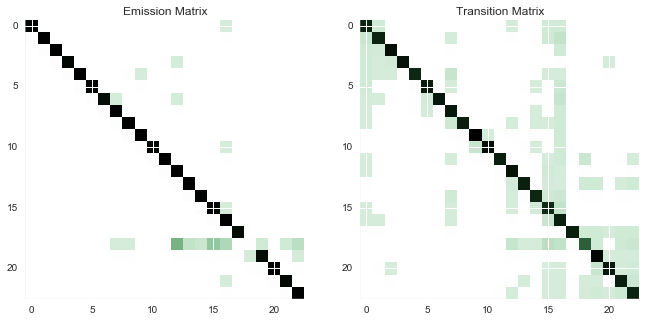

In [11]:
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
plt.title('Emission Matrix')
plt.imshow(fitted.emissionprob_,interpolation='none',cmap=my_cmap)
plt.subplot(1,2,2)
plt.title('Transition Matrix')
plt.imshow(fitted.transmat_,interpolation='none',cmap=my_cmap)
plt.subplot(1,2,2)


* Note that we start with guesses that the diagonals are approx = 1/3. Hmmlearn behaves as one might expect allowing mass along the diagonal to accumulate. The diagonals are printed below:

In [12]:
np.round(np.diag(fitted.emissionprob_),2)

array([ 0.96,  0.98,  0.97,  0.94,  0.98,  0.96,  0.93,  0.96,  0.96,
        0.98,  0.95,  0.97,  0.98,  0.97,  0.96,  0.96,  0.97,  0.94,
        0.  ,  0.93,  0.96,  0.95,  0.96])

In [13]:
np.round(np.diag(fitted.transmat_),2)

array([ 0.81,  0.81,  0.87,  0.86,  0.8 ,  0.84,  0.85,  0.85,  0.82,
        0.92,  0.87,  0.82,  0.85,  0.82,  0.8 ,  0.79,  0.82,  0.83,
        0.61,  0.89,  0.83,  0.83,  0.81])

* Check we have indeed converged.

In [14]:
fitted.monitor_.converged

True

# 3. Application to real data (1979 cohort)

In [15]:
careers_all1979 = []
with open('input\CleanedDataLeadingRemoved1979.csv', 'rb') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        careers_all1979.append(np.array([i for i in row if i!=''], dtype=int)-1)
careers_all1979[:5]

[array([19, 19,  1, 19,  1,  1, 19, 19,  1, 19,  1, 19, 19, 19, 19, 19]),
 array([22, 22, 22, 22, 22, 19, 19, 19, 19, 19, 19, 19,  1,  1, 17, 17]),
 array([30, 25, 25, 25, 19,  0,  0, 18,  0, 24,  0,  0, 24,  0, 25, 25]),
 array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([22, 22, 26,  0,  0,  0,  0, 22,  0, 22,  0, 22, 22, 22,  0,  0])]

In [16]:
%%time
X1979 = np.concatenate(careers_all1979)
lengths1979 = [len(career) for career in careers_all1979]

model1979 = hmm.MultinomialHMM(n_components=31, n_iter=200,params='ste',tol=0.01, init_params='')

model1979.startprob_ = np.ones(31)/31.
model1979.transmat_ = gen_jitter(np.eye(31), 5)
model1979.emissionprob_ = gen_jitter(np.eye(31), 5)

fitted1979=model1979.fit(np.atleast_2d(X1979).T, lengths1979)


Wall time: 22min 45s


* Check we have converged.

In [17]:
fitted1979.monitor_.converged

True

* Plot the emission and transition matrices for both cohorts.

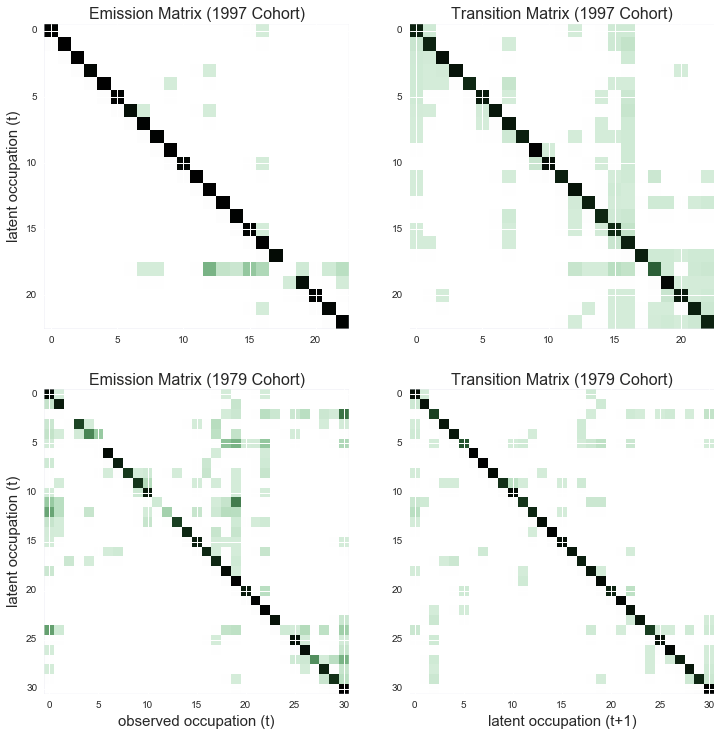

In [18]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.title('Emission Matrix (1997 Cohort)', fontsize=16)
# plt.xlabel('observed occupation (t)', fontsize=15)
plt.ylabel('latent occupation (t)', fontsize=15)
plt.imshow(fitted.emissionprob_,interpolation='none',cmap=my_cmap)
plt.subplot(2,2,2)
plt.title('Transition Matrix (1997 Cohort)', fontsize=16)
# plt.ylabel('latent occupation (t)', fontsize=15)
# plt.xlabel('latent occupation (t+1)', fontsize=15)
plt.imshow(fitted.transmat_,interpolation='none',cmap=my_cmap)

plt.subplot(2,2,3)
plt.title('Emission Matrix (1979 Cohort)', fontsize=16)
plt.xlabel('observed occupation (t)', fontsize=15)
plt.ylabel('latent occupation (t)', fontsize=15)
plt.imshow(fitted1979.emissionprob_,interpolation='none',cmap=my_cmap)
plt.subplot(2,2,4)
plt.title('Transition Matrix (1979 Cohort)', fontsize=16)
# plt.ylabel('latent occupation (t)', fontsize=15)
plt.xlabel('latent occupation (t+1)', fontsize=15)
plt.imshow(fitted1979.transmat_,interpolation='none',cmap=my_cmap)

plt.savefig("plots\hmm_matrices.png", bbox_inches='tight')


In [19]:
# # FOR POSTER
# plt.figure(figsize=(12,12))
# plt.subplot(2,2,1)
# plt.title('Emissions', fontsize=30)
# plt.ylabel('1997 Cohort', fontsize=30)
# plt.imshow(fitted.emissionprob_,interpolation='none',cmap=my_cmap)
# plt.subplot(2,2,2)
# plt.title('Transitions', fontsize=30)
# plt.imshow(fitted.transmat_,interpolation='none',cmap=my_cmap)

# plt.subplot(2,2,3)
# plt.ylabel('1979 Cohort', fontsize=30)
# plt.imshow(fitted1979.emissionprob_,interpolation='none',cmap=my_cmap)
# plt.subplot(2,2,4)
# plt.imshow(fitted1979.transmat_,interpolation='none',cmap=my_cmap)

# plt.savefig("hmm_matrices.png")


* Some analysis on why there are peculiar rows in the emission matrices. E.g. row 18 of the 1997 E matrix and rows 11, 12 and 24 of the 1979 E matrix.
* As determined below these occupations have very few instances with which to train probabilities.
* Suggest either merging them with closest analog or dropping the handful of career paths that contain them altogether.

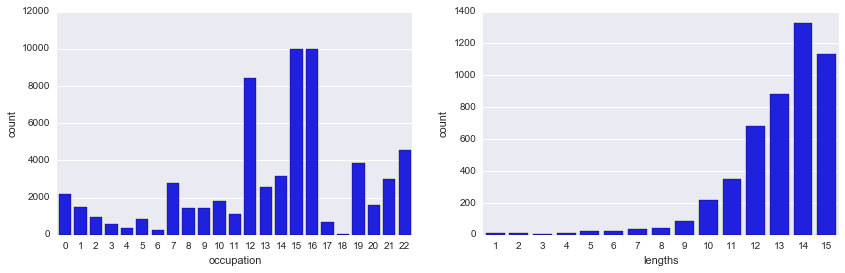

In [20]:
occupation_df = pd.DataFrame(zip(X,np.ones(len(X),dtype=int)), columns=['occupation','count'])
occupation_df = occupation_df.groupby('occupation').sum().reset_index()

length_df = pd.DataFrame(zip(lengths,np.ones(len(lengths),dtype=int)), columns=['lengths','count'])
length_df = length_df.groupby('lengths').sum().reset_index()

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
sns.barplot(x="occupation", y="count", data=occupation_df, color='blue')
plt.ylabel('count')
plt.subplot(1,2,2)
sns.barplot(x="lengths", y="count", data=length_df, color='blue')
plt.ylabel('count')

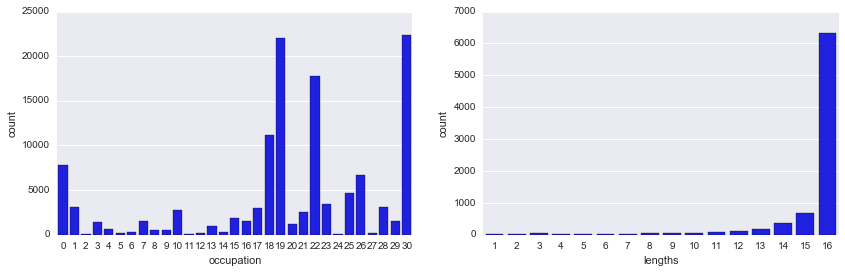

In [21]:
occupation_df1979 = pd.DataFrame(zip(X1979,np.ones(len(X1979),dtype=int)), columns=['occupation','count'])
occupation_df1979 = occupation_df1979.groupby('occupation').sum().reset_index()

length_df1979 = pd.DataFrame(zip(lengths1979,np.ones(len(lengths1979),dtype=int)), columns=['lengths','count'])
length_df1979 = length_df1979.groupby('lengths').sum().reset_index()

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
sns.barplot(x="occupation", y="count", data=occupation_df1979, color='blue')
plt.ylabel('count')
plt.subplot(1,2,2)
sns.barplot(x="lengths", y="count", data=length_df1979, color='blue')
plt.ylabel('count')

# 4. Analysis for results write-up.

In [22]:
def get_ranked(list_to_rank, ascending=True):
    '''
    input = array of occupations to rank
    output = sorted dataframe with occupation code
    '''
    list_fmt = list(list_to_rank)
    occ_code = np.arange(len(list_to_rank))+1
    rank_df = pd.DataFrame(zip(occ_code,list_fmt), columns=['occ_code','sortonme'])
    rank_df = rank_df.sort_values(by='sortonme', ascending=ascending)
    return rank_df


In [23]:
# most rigid career
# healthcare
get_ranked(fitted.transmat_.diagonal(), ascending=False).head(5)


,occ_code,sortonme
9,10,0.921471
19,20,0.890731
10,11,0.870223
2,3,0.867567
3,4,0.861395


In [24]:
# most common terminal career - least barrier to entry
# sales and office/admin
get_ranked(np.sum(fitted.transmat_, axis=0), ascending=False).head(5)


,occ_code,sortonme
16,17,1.489673
15,16,1.240804
0,1,1.135978
7,8,1.105974
19,20,1.083050


In [25]:
# most noisy occupation
# construction
# peculiar behaviour in Fishing and Hunting, Forest and Logging discussed above
get_ranked(fitted.emissionprob_.diagonal()).head(5)
    

,occ_code,sortonme
18,19,0.000852
6,7,0.927351
19,20,0.928124
17,18,0.936430
3,4,0.943770


In [26]:
print 'proportion of mass along diagonal (noise) emission 1997:'
print np.sum(fitted.emissionprob_.diagonal())/fitted.emissionprob_.shape[0]

print '\nproportion of mass along diagonal (noise) emission 1979:'
print np.sum(fitted1979.emissionprob_.diagonal())/fitted1979.emissionprob_.shape[0]

print '\nproportion of mass along diagonal (rigidity) transition 1997:'
print np.sum(fitted.transmat_.diagonal())/fitted.transmat_.shape[0]

print '\nproportion of mass along diagonal (rigidity) transition 1979:'
print np.sum(fitted1979.transmat_.diagonal())/fitted1979.transmat_.shape[0]

proportion of mass along diagonal (noise) emission 1997:
0.917644334882

proportion of mass along diagonal (noise) emission 1979:
0.714348020178

proportion of mass along diagonal (rigidity) transition 1997:
0.826689368425

proportion of mass along diagonal (rigidity) transition 1979:
0.882074480252


* I.e. 1997 cohort exhibits less noise but also less rigidity.